<a href="https://colab.research.google.com/github/ellenxwchen/Latexify-Handwriting/blob/master/Latexify-Handwriting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Splitting the Data 
Don't run the code in this section please! 

In [ ]:
pip install split-folders tqdm

In [ ]:
import split_folders
##Add a shortcut to aps360 into your drive
!unzip '/content/drive/My Drive/aps360/data/correct.zip' -d '/root/datasets'

In [ ]:
data_dir = data_dir = '/root/datasets/correct'
split_folders.ratio(data_dir, output='/content/drive/My Drive/aps360/data', seed=1337, ratio=(.8, .1, .1)) 

# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(50) # set the random seed
train = '/content/drive/My Drive/aps360/data1/train'
val = '/content/drive/My Drive/aps360/data1/val'
test = '/content/drive/My Drive/aps360/data1/test'

data_transform = transforms.Compose(
        [transforms.RandomResizedCrop(45, scale=(1,1)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.ImageFolder(root=train,transform=data_transform)
val_dataset = torchvision.datasets.ImageFolder(root=val,transform=data_transform)
test_dataset = torchvision.datasets.ImageFolder(root=test,transform=data_transform)

# Helper Functions for Training

In [ ]:
## Get accuracy of the model on different sets of data
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
## Find loss for the model on specified data loader, used in training
def find_loss(model, valid_loader, criterion):
  for imgs, labels in valid_loader:
    img = imgs.cuda()
    labels = labels.cuda()
    recon_val = model(imgs.cuda())
    loss_val = criterion(recon_val, labels.cuda())

  return loss_val

In [ ]:
## Training function for non-transfer learning 
def train(model, data, batch_size=20, num_epochs=1,weight_decay=.0000):
    torch.manual_seed(50)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=weight_decay)

    iters, val_loss, train_loss, train_acc, val_acc = [], [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
          
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch


            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader)) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        iters.append(n)

        loss_validation = find_loss(model, val_loader, criterion)

        train_loss.append(float(loss)/batch_size)             # compute *average* loss
        val_loss.append(float(loss_validation)/batch_size)

        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        n += 1
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation") 
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_loader))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))
    

In [ ]:
## Training function for transfer learning 
def train_transfer(model, data, batch_size=20, num_epochs=1, weight_decay = .0001):
    torch.manual_seed(50)
    
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = weight_decay)

    iters, val_loss, train_loss, train_acc, val_acc = [], [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            imgs = imgs.to(device)
            labels = labels.to(device)
            
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch


            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader)) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        # save the current training information
        iters.append(n)

        loss_validation = find_loss(model, val_loader, criterion)

        train_loss.append(float(loss)/batch_size)             # compute *average* loss
        val_loss.append(float(loss_validation)/batch_size)

        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        n += 1
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation") 
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_loader))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

In [ ]:
## Training function for transfer learning, saves every iteration
## Gives more information in the graph, but takes a longer time
def train_transfer_iteration(model, data, batch_size=20, num_epochs=1, iteration_num= 10,learning_rate = 0.001, weight_decay = .0001):
    torch.manual_seed(50)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0015, weight_decay = weight_decay)

    iters, val_loss, train_loss, train_acc, val_acc = [], [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):

        ## Drops learning rate after most of the inital training is done
        learn_rate_change = learning_rate
        #if n == round(num_epochs * 0.5):
          #learn_rate_change = learning_rate *0.25
        optimizer = optim.Adam(model.parameters(), lr=learn_rate_change, weight_decay = weight_decay)

        for imgs, labels in iter(train_loader):
          
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            imgs = imgs.to(device)
            labels = labels.to(device)
            
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch


            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader)) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


            # save the current training information
            iters.append(n)

            loss_validation = find_loss(model, val_loader, criterion)

            train_loss.append(float(loss)/batch_size)             # compute *average* loss
            val_loss.append(float(loss_validation)/batch_size)

            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
            val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            n += 1
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation") 
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_loader))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

# Training Our Best Model

***new

Iteration:  0 Progress:   0.00  % Time Elapsed:  124.85 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  241.21 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  365.97 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  489.45 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  605.41 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  726.09 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  848.23 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  964.15 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  1079.74 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  1205.72 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  1319.59 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  1438.67 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  1556.20 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  1672.12 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  1788.43 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  1812.34 s 
Epoch 0 Finished.  Time per Epoch:  2042.36 s 
I

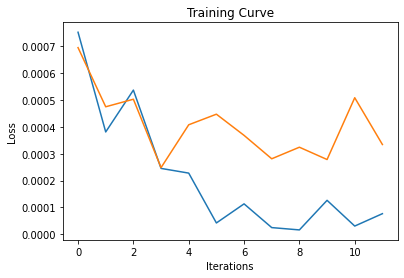

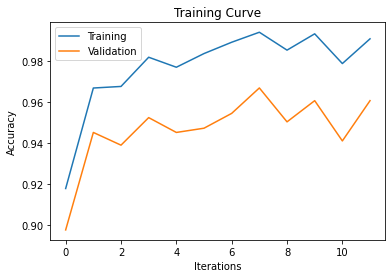

Final Training Accuracy: 0.9908834103749358
Final Validation Accuracy: 0.9607032057911065
Total time:   2361.47 s  Time per Epoch:  196.79 s 


In [ ]:
use_cuda = True
from torchvision import datasets, models, transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft_2 = models.resnet34(pretrained=True)

##Finetuning 

#for param in model_ft_2.parameters():
#    param.requires_grad = False

model_ft_2 = model_ft_2.to(device)

num_ftrs_2 = model_ft_2.fc.in_features

model_ft_2.fc = nn.Linear(num_ftrs_2, 91)

##lr = 0.001
train_transfer(model_ft_2.cuda(), train_dataset, batch_size=512, num_epochs=12,weight_decay = 0.000)

Iteration:  0 Progress:   0.00  % Time Elapsed:   6.83 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  13.60 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  20.39 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  27.22 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  34.00 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  40.74 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  47.44 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  52.95 s 
Epoch 0 Finished.  Time per Epoch:  78.88 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  85.64 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  92.44 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  99.18 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  105.96 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  112.67 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  119.54 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  126.31 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  131.82 s 
Epoch 1 Finished.  Tim

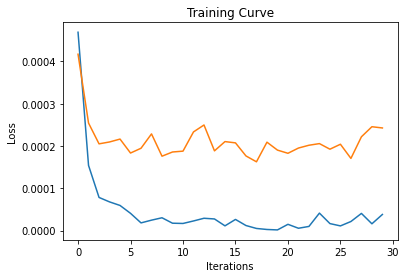

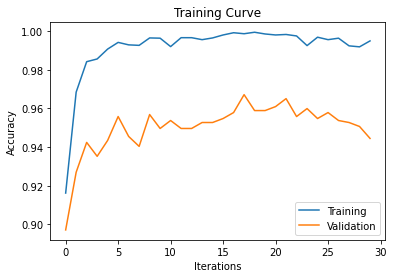

Final Training Accuracy: 0.9941131302789864
Final Validation Accuracy: 0.9444444444444444
Total time:   2356.96 s  Time per Epoch:  78.57 s 


In [ ]:
use_cuda = True
from torchvision import datasets, models, transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft_2 = models.resnet34(pretrained=True)

model_ft_2 = model_ft_2.to(device)
num_ftrs_2 = model_ft_2.fc.in_features
model_ft_2.fc = nn.Linear(num_ftrs_2, 89)

##lr = 0.001
train_transfer(model_ft_2.cuda(), train_dataset, batch_size=1000, num_epochs=30,weight_decay = 0.000)

Iteration:  0 Progress:   0.00  % Time Elapsed:   1.72 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:   3.41 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:   5.07 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:   6.80 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:   8.54 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  10.26 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  11.92 s 
Iteration:  0 Progress:   0.00  % Time Elapsed:  13.23 s 
Epoch 0 Finished.  Time per Epoch:  28.55 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  30.28 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  32.02 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  33.77 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  35.50 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  37.24 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  38.99 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  40.73 s 
Iteration:  1 Progress:   3.33  % Time Elapsed:  42.11 s 
Epoch 1 Finished.  Time per

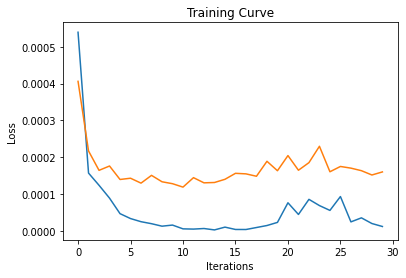

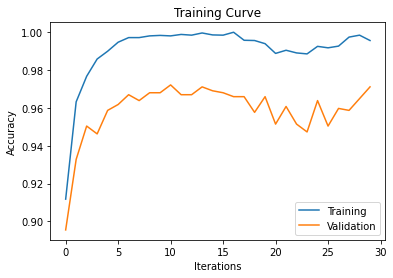

Final Training Accuracy: 0.9952491011813046
Final Validation Accuracy: 0.9710444674250258
Total time:   857.01 s  Time per Epoch:  28.57 s 


In [ ]:
use_cuda = True
from torchvision import datasets, models, transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft_2 = models.resnet34(pretrained=True)

#for param in model_ft_2.parameters():
#    param.requires_grad = False

model_ft_2 = model_ft_2.to(device)

num_ftrs_2 = model_ft_2.fc.in_features
model_ft_2.fc = nn.Linear(num_ftrs_2, 91)

##lr = 0.001
train_transfer(model_ft_2.cuda(), train_dataset, batch_size=1000, num_epochs=30,weight_decay = 0.000)

# Data Visualization

In [ ]:
# Visualize some sample data
train = '/content/drive/My Drive/aps360/data1/train'

data_transform = transforms.Compose(
        [transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.ImageFolder(root=train,transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

import numpy as np
import matplotlib.pyplot as plt

classes = np.array(['!','(',')','+','-','0','1','2','3','4','5','6',
           '7','8','9','=','A','B','D','E','F','G','H','I',
           'J','L','M','N','Q','R','T','Y','\delta','[',']','a',
           r'\alpha','|','b',r'\beta','c','d','\div','e','\exists','f',r'\forall','\diagup',
           'g','\gamma','\geq','\gt','h','i','\in','\infty','\int','j',
           'k','l','\lambda','\ldots','\leq','\lt','m','\mu','n',r'\neq','p','\phi',
           '\pi','\pm','\prime','q','r',r'\rightarrow','s','\sigma','\sqrt{}','\sum','t',r'\theta',
           r'\times','u','v','w','x','y','z','{','}'])

print(len(classes))

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

91


RuntimeError: ignored

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Run this helper function
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

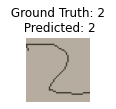

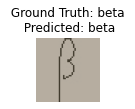

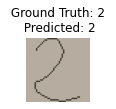

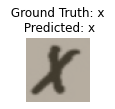

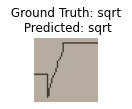

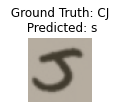

In [ ]:
##This function shows num_image # of images, and shows the ground truth vs the model's prediction of the image
def visualize_model_transfer(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(' Ground Truth: {}'.format(classes[labels[j]]) + ' \n Predicted: {}'.format(classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model_transfer(model_ft_2, num_images=6)

#Objection Detection - OpenCV

204 323 165 233
389 306 147 258
60 263 604 25
128 49 164 186
382 25 124 217
[[130  51 160 182]
 [206 325 161 229]
 [384  27 120 213]
 [391 308 143 254]]


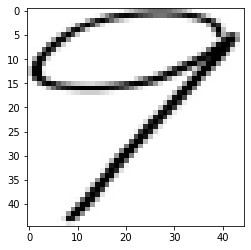

In [ ]:
##READING AN IMAGE AND GETTING THE BOUNDING BOXES
import cv2
import numpy as np
from numpy import array
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
folder =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos'
directory =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos/fraction.jpg'
os.chdir(folder) 

image = cv2.imread(directory)
plt.imshow(image, cmap='gray')
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blured = cv2.blur(gray, (5,5), 0)   
img_thresh = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
thresh = cv2.morphologyEx(img_thresh, cv2.MORPH_GRADIENT, rect_kernel)

# Find contours, obtain bounding box, extract and save ROI
ROI_number = 0
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boxes = 0
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

result_array = np.empty((0,4), int)

for c in cnts:
    boxes +=1
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    ROI = original[y:y+h, x:x+w]
    print(x,y,w,h)
    if w >25 and h>25:
      result_array = np.append(result_array, np.array([[x+2,y+2,w-4,h-4]]),axis=0)
    ##SORTED ARRAY TO GET THE BOXES FROM LEFT TO RIGHT
    sorted_array = result_array[np.argsort(result_array[:, 0])]

    save_dir = r'/content/drive/My Drive/testing_imgs/after_contour/'
    name = str(boxes) +'.jpg'
    total_dir = save_dir+name

letter = image[y+2:y+h-2,x+2:x+w-2]
dim = (45,45)
resized_letter = cv2.resize(letter, dim,interpolation = cv2.INTER_AREA)
plt.imshow(resized_letter,cmap='gray')
cv2.waitKey()
print(sorted_array)

In [ ]:
##Getting the boxes, and saving it to a folder in order (eg. 1.jpg, 2.jpg)
boxes = 0
for a in sorted_array:
  x=a[0]
  y=a[1]
  w=a[2]
  h = a[3]
  letter = image[y+2:y+h-2,x+2:x+w-2]
  save_dir = r'/content/drive/My Drive/testing_imgs/after_contour/'
  name = str(boxes) +'.jpg'
  total_dir = save_dir+name
  dim = (45,45)
  resized_letter = cv2.resize(letter, dim,interpolation = cv2.INTER_AREA)
  cv2.imwrite(total_dir,resized_letter)
  boxes +=1

In [ ]:
##Probably extra code, but basically "send" images to the model and have it classify it
def send_data(model):
    num_images = 2
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

  
    test_loader = torch.utils.data.DataLoader(val_dataset,batch_size=32,shuffle = True)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            print(inputs[1])
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(' Ground Truth: {}'.format(classes[labels[j]]) + ' \n Predicted: {}'.format(classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
#Get the images from the bounding boxes
crop = '/content/drive/My Drive/testing_imgs'
data_transform = transforms.Compose(
        [transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Will save all the predictions from the model
saveChar = []

was_training = model_ft_2.training
model_ft_2.eval()

contour_dataset = torchvision.datasets.ImageFolder(root=crop,transform=data_transform)
contour_loader = torch.utils.data.DataLoader(contour_dataset,batch_size=32)
with torch.no_grad():
  for features,labels in iter(contour_loader):
    features = features.to(device)
    labels = labels.to(device)
    outputs = model_ft_2(features)
    _,pred = torch.max(outputs, 1)

    #Saving all the predictions from the model
    for j in range(features.size()[0]):
      saveChar.append(classes[pred[j]])
  print(saveChar) #the double \\ is fine, needed to put into LaTeX

['\\times', '\\sum', 'z', '2', 'x', '1', '3', 't', '2', 'z', '=', 'k']


In [ ]:
#TotalString will save the whole equation
totalString=" "

#Run through the individual chars and puts them together
for i in range(0, len(saveChar)):
  totalString = totalString + saveChar[i] + " "
print(totalString)

from IPython.display import HTML, Math
def latexify(e):
  display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
         "latest.js?config=default'></script>"))
  return Math(latex(e))

display(latexify(totalString))

 \times \sum z 2 x 1 3 t 2 z = k 


<IPython.core.display.Math object>

In [ ]:
##Sending data !! Not sure if this is correct but use the above method
def send_data(model):
    num_images = 2
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    inputs = torch.from_numpy(resized_letter)

    inputs = inputs.permute(2,0,1)      # move the channel dimension to the beginning
    inputs = inputs.unsqueeze(0)
    
    with torch.no_grad():
        print(inputs.shape)
        inputs = inputs.float()
        inputs = inputs.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('Predicted: {}'.format(classes[preds[j]]))
            imshow(inputs.cpu().data[j])
            plt.imshow(resized_letter,cmap='gray')
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
        model.train(mode=was_training)

torch.Size([1, 3, 45, 45])


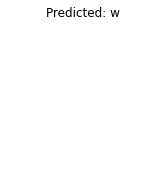

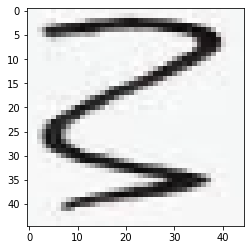

In [ ]:
send_data(model_ft_2)

# Test Accuracy

In [ ]:
batch_size = 1000
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(get_accuracy(model_ft_2,test_loader))

0.9592850049652433


In [ ]:
from numpy import zeros
import numpy as np
import matplotlib.pyplot as plt

#Run this helper function
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## This function takes the model, and looks through num_images # of the data
## Then, it keeps track of the accuracy of each class -- this is useful for our data analysis
def test_acc_transfer(model, num_images=100):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    correct_array = zeros([1,89])
    total_array = zeros([1,89])

    ##test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1000, shuffle=True)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                #if classes[labels[j]] == 'n':
                if (classes[preds[j]] == classes[labels[j]]):
                    correct_array[0][labels[j]] +=1
                total_array[0][labels[j]]+=1  

            acc_array = correct_array / total_array
            for i in range(0, acc_array.shape[1]):
              print(classes[i], acc_array[0][i], '\n')
          
          #print(acc_array)

                  #if images_so_far == num_images:
                  #  model.train(mode=was_training)
                  #  return

        model.train(mode=was_training)


test_acc_transfer(model_ft_2,num_images = 20)

In [ ]:
## This function takes a model, a num_images #, and a class as an input
## Then, it sends the num_images # of images of ONLY the class into the model
## It will then output the images, the ground truth, and what the model's predition was -- good for the false positive / false negative analysis
def test_accuracy_indiv(model, num_images=6,string_input='a'):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    correct = 0
    total = 0


    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if classes[labels[j]] == string_input:
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title(' Ground Truth: {}'.format(classes[labels[j]]) + ' \n Predicted: {}'.format(classes[preds[j]]))
                    imshow(inputs.cpu().data[j])
                    if classes[labels[j]] == classes[preds[j]]:
                      correct +=1
                    total +=1
                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
        model.train(mode=was_training)
        print(correct/total)

test_accuracy_indiv(model_ft_2,15,r'\delta')

# Putting Everything Together!


OpenCV for bounding boxes

In [ ]:
##Assuming that the photo is in FinalPhotos -- feel free to add as needed
def get_directory(photo="fraction"):
  if (photo == "fraction"):
    directories[0] =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos/fraction.jpg'
    directories[1] =  r'/content/drive/My Drive/aps360/crop/fraction/fraction1'
    directories[2] = r'/content/drive/My Drive/aps360/crop/fraction'
  if (photo == "mu"):
    directories[0] =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos/mu_not_equal.jpg'
    directories[1] =  r'/content/drive/My Drive/aps360/crop/mu_not_equal/mu_not_equal1'
    directories[2] = r'/content/drive/My Drive/aps360/crop/mu_not_equal'
  if (photo == "tan"):
    directories[0] =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos/tan.jpg'
    directories[1] =  r'/content/drive/My Drive/aps360/crop/tan/tan1'
    directories[2] = r'/content/drive/My Drive/aps360/crop/tan'
  if (photo == "sin"):
    directories[0] =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos/sin.jpg'
    directories[1] =  r'/content/drive/My Drive/aps360/crop/sin/sin1'
    directories[2] = r'/content/drive/My Drive/aps360/crop/sin'
  if (photo == "sup_pm_equ"):
    directories[0] =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos/sup_pm_equ.jpg'
    directories[1] =  r'/content/drive/My Drive/aps360/crop/sup_pm_equ/sup_pm_equ1'
    directories[2] = r'/content/drive/My Drive/aps360/crop/sup_pm_equ'
  if (photo == "sub_and_sup"):
    directories[0] =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos/sub_and_sup.jpg'
    directories[1] =  r'/content/drive/My Drive/aps360/crop/sub_and_sup/sub_and_sup1'
    directories[2] = r'/content/drive/My Drive/aps360/crop/sub_and_sup'
  if (photo == "sub_sup_script"):
    directories[0] =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos/sub_sup_script.jpg'
    directories[1] =  r'/content/drive/My Drive/aps360/crop/sub_sup_script/sub_sup_script1'
    directories[2] = r'/content/drive/My Drive/aps360/crop/sub_sup_script'
  if (photo == "AFM"):
    directories[0] =r'/content/drive/My Drive/aps360/fullEquationDataset/testImage7.jpg'
    directories[1] =  r'/content/drive/My Drive/aps360/crop/testImage5/testImage5'
    directories[2] = r'/content/drive/My Drive/aps360/crop/testImage5'
  if (photo == "forall_equ_inf"):
    directories[0] =r'/content/drive/My Drive/aps360/fullEquationDataset/testImage1.jpg'
    directories[1] =  r'/content/drive/My Drive/aps360/crop/testImage1/testImage1'
    directories[2] = r'/content/drive/My Drive/aps360/crop/testImage1'
  if (photo == "alpha_geq"):
    directories[0] =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos/alpha_geq-1.jpg'
    directories[1] =  r'/content/drive/My Drive/aps360/crop/alpha_geq/alpha_geq1'
    directories[2] = r'/content/drive/My Drive/aps360/crop/alpha_geq'
  if (photo == "AFM-final"):
    directories[0] =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos/AFM-final.jpg'
    directories[1] =  r'/content/drive/My Drive/aps360/crop/AFM-final/AFM-final1'
    directories[2] = r'/content/drive/My Drive/aps360/crop/AFM-final'


directories = ["","",""]

get_directory("fraction")

directory = directories[0]
crop = directories[1]
crop_dir = directories[2]

60 263 604 25
128 49 164 186
204 323 165 233
382 25 124 217
389 306 147 258


-1

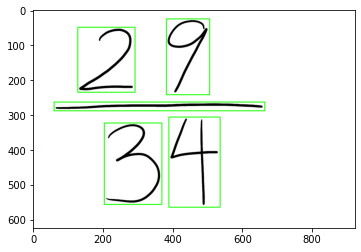

In [ ]:
import cv2
import numpy as np
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
folder =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos'

os.chdir(folder) 

image = cv2.imread(directory)
#plt.imshow(image, cmap='gray')
original = image.copy()
# convert image to gray from RGB
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blur image 
blured = cv2.blur(gray, (15,15), 0)   

x_list=[]
w_list=[]
y_list=[]
h_list=[]

image = cv2.imread(directory)
#plt.imshow(image, cmap='gray')
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blured = cv2.blur(gray, (5,5), 0)   
img_thresh = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
thresh = cv2.morphologyEx(img_thresh, cv2.MORPH_GRADIENT, rect_kernel)

# Find contours, obtain bounding box, extract and save ROI
ROI_number = 0
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = cnts[0] if len(cnts) == 2 else cnts[1]
idx = 0
height,width,channels = image.shape

result_array = np.empty((0,4), int)

# # go through contours and put bounding boxes on them as well as save them
sorted_ctrs = sorted(cnts, key=lambda cnts: cv2.boundingRect(cnts))
for c in sorted_ctrs:
    os.chdir(crop) 
    idx += 1
    x,y,w,h = cv2.boundingRect(c)
    print(x,y,w,h)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    ROI = original[y:y+h, x:x+w]
    cv2.imwrite(str(idx) + '.jpg', ROI)
    result_array = np.append(result_array, np.array([[x+2,y+2,w-4,h-4]]),axis=0)
    ##SORTED ARRAY TO GET THE BOXES FROM LEFT TO RIGHT
    sorted_array = result_array[np.argsort(result_array[:, 0])]

    x_list.append(x)
    w_list.append(w)
    y_list.append(y)
    h_list.append(h)

plt.imshow(image,cmap='gray')
cv2.waitKey()

Model classifies chracters for the first time

In [ ]:
#https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/2
import torchvision.transforms.functional as F
import numpy as np
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, (255,255,255), 'constant')

In [ ]:
#crop_dir = '/content/drive/My Drive/aps360/crop/fraction'
data_transform = transforms.Compose([SquarePad(), transforms.RandomResizedCrop(45, scale=(1,1)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


contour_dataset = torchvision.datasets.ImageFolder(root=crop_dir,transform=data_transform)
contour_loader = torch.utils.data.DataLoader(contour_dataset,batch_size=10,shuffle = False)



In [ ]:
classes = ['!','(',')','+','-','0','1','2','3','4','5','6',
           '7','8','9','=','A','B','D','E','F','G','H','I',
           'J','L','M','N','Q','R','T','Y','\Delta','[',']','a',
           r'\alpha','b',r'\beta','c',r'\cdots','d','\div','e','\exists','f',r'\forall','\diagup',
           'g','\gamma','\geq','\gt','h','i','\in','\infty','\int','j',
           'k','\lambda','\ldots','\leq','\lt','m','\mu','n',r'\neq','p','\phi',
           '\pi','\pm','\prime','q','r',r'\rightarrow','s','\sigma','\sqrt{}','\sum',r'\theta',
           r'\times','u','v','w','x','y','z','{','}','\\cos(','\\sin(','\\tan(']

In [ ]:
pred = []
for features,labels in iter(contour_loader):
  features = features.to(device)
  labels = labels.to(device)
  outputs = model_ft_2(features)
  pred = outputs.max(1, keepdim=True)[1]


NameError: ignored

In [ ]:
for i in range(features.size()[0]):
  print(classes[pred[i]])

IndexError: ignored

In [ ]:
j=0
saveChar = []
checkSpecial = False

y_avg = sum(y_list) / len(y_list)
array_fraction=[0]
for i in range(0,len(x_list)): 
  if (classes[pred[i]]=='-'):
    print('character ',str(i), 'is -')
  elif (sorted_array[i][1] <= y_avg-50):
    print('character ',str(i),'is num')
    array_fraction.append(1)
  elif (sorted_array[i][1] + sorted_array[i][3]>= y_avg+50):
    print('character ',str(i),'is denom')
    array_fraction.append(2)
print(array_fraction)

while j < features.size()[0]:
    #### FRACTION ####   
    area_height = height/5
    if ((classes[pred[j]] == '-') and (y_avg-area_height<=sorted_array[j][1]<=y_avg+area_height) and (sorted_array[j+1][1] <= y_avg+area_height) and (sorted_array[j+2][1]+sorted_array[j+2][3] >= y_avg-area_height)):
      saveChar.append('\\frac{')
      checkSpecial = True      
      count_fraction=0
      for num in range(j+1,len(array_fraction)):
        if (array_fraction[num] == 1):
          saveChar.append(classes[pred[num]])
          count_fraction+=1
      saveChar.append('}{')
      for denom in range(j+1,len(array_fraction)):
        if (array_fraction[denom] == 2):
          saveChar.append(classes[pred[denom]])
          count_fraction+=1
      saveChar.append('}')
      j=j+count_fraction+1
      continue
    if checkSpecial == True:
      saveChar.append(classes[pred[j]])
    j +=1
print(saveChar) #the double \\ is fine, needed to put into LaTeX
saveChar=[]

In [ ]:
#Step 5 (but also optional)
contour_dataset = torchvision.datasets.ImageFolder(root=crop_dir,transform=data_transform)
contour_loader = torch.utils.data.DataLoader(contour_dataset,batch_size=32)

# obtain one batch of training images
dataiter = iter(contour_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(len(x_list)):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[pred[idx]])

Check for the start of special characters.
NOTE:If last chracter is a special character this code will not work

In [ ]:

index = []

for i in range(features.size()[0]):
  # looking for equal sign
  if(classes[pred[i]]=='-'):
    index.append(i+1)
  # looking for pm
  if(classes[pred[i]]=='+'):
    index.append(i+1)
  # looking for LE character
  if(classes[pred[i]]=='\lt'):
    index.append(i+1)
  # looking for GE symbol
  if(classes[pred[i]]=='\geq'):
    index.append(i+1)
  # looking for exclamation mark
  if(classes[pred[i]]=='\prime'):
    index.append(i+1)
 

NameError: ignored

Extend bounding box and delete extra bounding boxes. Save cropped images that end with PC.

In [ ]:
def index_of(val, in_list):
    try:
        return in_list.index(val)
    except ValueError:
        return -1 

In [ ]:
import cv2
import numpy as np
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
folder =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos'
#directory =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos/fraction.jpg'
crop =  r'/content/drive/My Drive/aps360/crop/alpha_geq_PC/alpha_geq_PC1'

#directory =r'/content/drive/My Drive/aps360/fullEquationDataset/FinalPhotos/mu_not_equal.jpg'
#crop =  r'/content/drive/My Drive/aps360/crop/fraction/fraction1'

os.chdir(folder) 

image = cv2.imread(directory)
#plt.imshow(image, cmap='gray')
original = image.copy()
# convert image to gray from RGB
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blur image 
blured = cv2.blur(gray, (15,15), 0)   
image = cv2.imread(directory)
#plt.imshow(image, cmap='gray')
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blured = cv2.blur(gray, (5,5), 0)   
img_thresh = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
thresh = cv2.morphologyEx(img_thresh, cv2.MORPH_GRADIENT, rect_kernel)
height,width,channels = image.shape

ROI_number = 0
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = cnts[0] if len(cnts) == 2 else cnts[1]
idx = 0
sorted_ctrs = sorted(cnts, key=lambda cnts: cv2.boundingRect(cnts))
coods = []
value = []
x_list=[]
y_list=[]
h_list=[]
w_list=[]
for c in sorted_ctrs:
    idx += 1
    x,y,w,h = cv2.boundingRect(c)
    if(index_of(idx,index)!=-1):
      y = y - 75
      coods+=(x,y,w,h+100)
      value.append(int(idx)-1)
    else:
      coods+=cv2.boundingRect(c)

# code to turn the list of sorted x,y,w,h into an array
# equilavent to sorted_array
coods = np.array(coods)
first_dim = len(coods)/4
coods = coods.reshape(int(first_dim),4)
s = len(value)
delInd = []

# Delete extra bounding boxes
for j in range(s):
  i = 0
  for c in iter(coods):
    if(i==value[j] and coods[i+1][0]<=c[0]+30):
      delInd.append(i+1)
    i+=1
coods = np.delete(coods,(delInd),0)
idx = 0

os.chdir(crop) 
# Save ROI
for c in coods:
  x_list.append(x)
  y_list.append(y)
  w_list.append(w)
  h_list.append(h)
  idx+=1
  x = c[0]
  y = c[1]
  w = c[2]
  h = c[3]
  cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
  ROI = original[y:y+h, x:x+w]
  saveChar=[]
  if (len(saveChar)==0):
    print("save image")
    cv2.imwrite(str(idx) + '.jpg', ROI)
print(coods)

plt.imshow(image,cmap='gray')
cv2.waitKey()

NameError: ignored

Reclassify new cropped images, that have extended bounding boxes

In [ ]:

crop =  r'/content/drive/My Drive/aps360/crop/alpha_geq_PC'
data_transform = transforms.Compose([SquarePad(), transforms.RandomResizedCrop(45, scale=(1,1)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


contour_dataset = torchvision.datasets.ImageFolder(root=crop,transform=data_transform)
contour_loader = torch.utils.data.DataLoader(contour_dataset,batch_size=64,shuffle = False)

In [ ]:
pred = []
for features,labels in iter(contour_loader):
  features = features.to(device)
  labels = labels.to(device)
  outputs = model_ft_2(features)
  pred = outputs.max(1, keepdim=True)[1]

In [ ]:
for i in range(features.size()[0]):
  print(classes[pred[i]])

\alpha
\geq
s
\beta


In [ ]:
#Step 5 (but also optional)
contour_dataset = torchvision.datasets.ImageFolder(root=crop,transform=data_transform)
contour_loader = torch.utils.data.DataLoader(contour_dataset,batch_size=32)

# obtain one batch of training images
dataiter = iter(contour_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(features.size()[0]):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[pred[idx]])

Check for trig and fractions

In [ ]:
saveChar=[]
j=0
checkSpecial = False

while j < features.size()[0]:
####TRIG####

    if(j < ((features.size()[0])-3)):
      if((classes[pred[j]] == 'c') and classes[pred[j+1]] == '0' and (classes[pred[j+2]]=='s' or classes[pred[j+2]]=='5')):
        checkSpecial = True
        saveChar.append(classes[92])
        j=j+4
        continue
      if((classes[pred[j]] == 'T' or classes[pred[j]] == '+') and (classes[pred[j+1]] == 'a' or classes[pred[j+1]] == '\\alpha') and (classes[pred[j+2]]=='n' or classes[pred[j+2]]=='N')):
        checkSpecial = True
        saveChar.append(classes[91])
        j=j+4
        continue
      if((classes[pred[j]] == 's' or classes[pred[j]] == '5') and (classes[pred[j+1]] == 'i' or classes[pred[j+1]] == '\\prime') and (classes[pred[j+2]]=='n' or classes[pred[j+2]]=='N')):
        checkSpecial = True
        saveChar.append(classes[90])
        j=j+4
        continue
    if checkSpecial == True:
      saveChar.append(classes[pred[j]])
    j +=1
print(saveChar) #the double \\ is fine, needed to put into LaTeX

[]


Neha's superscript/subscript

In [ ]:
array=[0]
x_list2 = []
y_list2= []
w_list2 = []
h_list2 = []

for c in coods: 
  x_list2.append(c[0])
  y_list2.append(c[1])
  w_list2.append(c[2])
  h_list2.append(c[3])

for i in range(len(x_list2)-1):   #0,1,2,3,...\
  # If there is denominator/numerators then do not check for subscripts/superscripts
  if (len(saveChar)==0):
    if y_list2[0]+h_list2[0]/2 > y_list2[i+1]+h_list2[i+1]:
      print('character number ',str(i+2),' is a superscript')
      array.append(1)
    elif y_list2[0]+h_list2[0]/2 < y_list2[i+1]:
      print('character number ',str(i+2),' is a subscript')
      array.append(2)
    else:
      array.append(0)
  else:
    continue

#array modifications/operations:
dummy_array=str(array)

#replace all 1, 2's with 3_super, 3_sub and vice versa for 2, 1 
dummy_array=dummy_array.replace('1, 2','3_super, 3_sub')
dummy_array=dummy_array.replace('2, 1','3_sub, 3_super')

dummy_array=dummy_array[1:len(dummy_array)-1]
dummy_array=dummy_array.replace(' ','')
dummy_array=dummy_array.split(',')

print('0 indicates normal, 1 indicates superscript, 2 indicates subscript, 3_super/3_sub indicates both a super/subscript on ONE base')

print(dummy_array)

#plt.plot(x+(w/2),y+(h/2),color='red', marker='o', linestyle='dashed',linewidth=2, markersize=3)
plt.imshow(image,cmap='gray')
cv2.waitKey()


Displaying in latex and checking subscript array

In [ ]:
savCharLength = len(saveChar)
print(savCharLength)
for i in range(features.size()[0]):
 if (savCharLength==0):
    saveChar.append(classes[pred[i]])
 else:
    continue


0


In [ ]:

totalString=" "
# if fraction type do not check for subscript
if (savCharLength!=0):
  for i in range(0, savCharLength):
      totalString = totalString + saveChar[i] + " "
else:
  for i in range(0, len(saveChar)):
    # check for normal
    if(dummy_array[i]=='0'):
      totalString = totalString + saveChar[i] + " "
    # check for superscript
    if(dummy_array[i]=='1' or dummy_array[i]=='3_super'):
      totalString = totalString + '^'+saveChar[i] + " "    
    # check for subscript
    if(dummy_array[i]=='2'or dummy_array[i]=='3_sub'):
      totalString = totalString + '_'+saveChar[i] + " "  
     

print(totalString)

from IPython.display import HTML, Math
def latexify(e):
  display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
         "latest.js?config=default'></script>"))
  return Math(e)

display(latexify(totalString))
#display(latexify("5^6"))

 \alpha \geq 5 \beta 


<IPython.core.display.Math object>